# Лабораторная №1 - Нейронная сеть прямого распространения

## Решаемая задача: распознавание рукописных символов

В данном ноутбуке представлено распознавание рукописных цифр (10 классов) с использованием самописной нейронной сети прямого распространения.

### Данные
Датасет - MNIST. Скачиваем и выполняем предобработку

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_test, y_test), _) = pickle.load(f, encoding="latin-1")

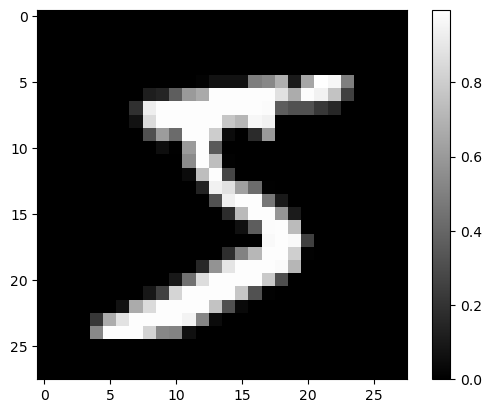

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.grid(False)

Данные уже нормализованы - цвет отдельного пикселя изменяется от 0 до 1

### Реализация сети
Ниже представлены две реализации:
* HardcodedNetwork - жестко заданная архитектура:
    - входной слой 
    - 1-й скрытый слой с активацией ReLU 
    - 2-й скрытый слой с активацией ReLU 
    - выходной слой с активацией softmax
* Network - обобщенная реализация, помимо количества нейронов в каждом слое можно менять количество слоёв, функции активации, веса и смещения

In [11]:
import numpy as np
import time

def ReLU(x, derivative=False):
    return x * (x > 0) if not derivative else x > 0


def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=1, keepdims=True)


class HardcodedNetwork:

    def __init__(self, sizes, batch_size=64):
        self.input_layer_size = sizes[0]
        self.hidden_layer_1_size, self.hidden_layer_2_size = sizes[1], sizes[2]
        self.output_layer_size = sizes[3]

        self.batch_size = batch_size

        self.__xavier_init(sizes)

    def __xavier_init(self, sizes):
        fan_in, fan_out = sizes[0], sizes[1]
        limit = np.sqrt(6 / (fan_in + fan_out))
        self.weights1 = np.random.uniform(-limit, limit, size=(fan_in, fan_out))

        fan_in, fan_out = sizes[1], sizes[2]
        limit = np.sqrt(6 / (fan_in + fan_out))
        self.weights2 = np.random.uniform(-limit, limit, size=(fan_in, fan_out))

        fan_in, fan_out = sizes[2], sizes[3]
        limit = np.sqrt(6 / (fan_in + fan_out))
        self.weights3 = np.random.uniform(-limit, limit, size=(fan_in, fan_out))

        self.biases1 = np.zeros((1, self.hidden_layer_1_size))
        self.biases2 = np.zeros((1, self.hidden_layer_2_size))
        self.biases3 = np.zeros((1, self.output_layer_size))

    def __forward(self, x):
        input_activations = np.array(x).reshape(1, len(x))

        self.hidden1_activations = ReLU(np.dot(input_activations, self.weights1) + self.biases1)

        self.hidden2_activations = ReLU(np.dot(self.hidden1_activations, self.weights2) + self.biases2)

        self.output_activations = softmax(np.dot(self.hidden2_activations, self.weights3) + self.biases3)

        return self.output_activations

    def __backprop(self, x, y_valid):
        input_activations = np.array(x).reshape(1, len(x))
        y_onehot = self.__onehot(y_valid)

        self.__forward(x)

        output_error = self.output_activations - y_onehot
        self.dW3 = np.dot(self.hidden2_activations.T, output_error) 
        self.dB3 = np.sum(output_error, axis=0, keepdims=True)

        hidden2_error = np.dot(output_error, self.weights3.T) * ReLU(self.hidden2_activations, derivative=True)
        self.dW2 = np.dot(self.hidden1_activations.T, hidden2_error)
        self.dB2 = np.sum(hidden2_error, axis=0, keepdims=True)

        hidden1_error = np.dot(hidden2_error, self.weights2.T) * ReLU(self.hidden1_activations, derivative=True)
        self.dW1 = np.dot(input_activations.T, hidden1_error)
        self.dB1 = np.sum(hidden1_error, axis=0, keepdims=True)

    def fit(self, x_train, y_train, x_test, y_test, epochs, learning_rate):
        time_data = []
        loss_data = []
        acc_data = []
        start = time.time()
        for epoch in range(epochs):
            total_loss = 0
            epoch_start = time.time()
            for x, y in zip(x_train, y_train):
                self.__backprop(x, y)
                y_onehot = self.__onehot(y)
                output = self.__forward(x)
                loss = -np.sum(y_onehot * np.log(output + 1e-8))
                total_loss += loss
                self.__update_params(learning_rate)
            avg_loss = total_loss / len(x_train)
            loss_data.append(avg_loss)
            print(f"====================================\n"
                  f"Epoch {epoch + 1}/{epochs}\nLoss: {avg_loss:.4f}")
            accuracy = self.test(x_test, y_test)
            acc_data.append(accuracy)
            print(f'Accuracy: {accuracy:.2f}%')
            time_data.append(time.time() - epoch_start)
        print(f'Training time: {time.time() - start:.2f}')
        return time_data, loss_data, acc_data

    def __update_params(self, learning_rate):
        self.weights1 -= learning_rate * self.dW1
        self.biases1 -= learning_rate * self.dB1

        self.weights2 -= learning_rate * self.dW2
        self.biases2 -= learning_rate * self.dB2

        self.weights3 -= learning_rate * self.dW3
        self.biases3 -= learning_rate * self.dB3

    def test(self, x_test, y_test):
        correct = 0
        for x, y in zip(x_test, y_test):
            prediction = self.predict(x)
            if prediction == y:
                correct += 1

        return correct / len(y_test) * 100

    def predict(self, x):
        return np.argmax(self.__forward(x))

    def __onehot(self, y):
        return np.eye(1, self.output_layer_size, k=y)

    def __str__(self):
        return (f'MyNetwork(\n\tinput layer of {self.input_layer_size} nodes,'
                f'\n\tweights between input and first hidden size of {self.weights1.shape},'
                f'\n\tfirst hidden layer of {self.hidden_layer_1_size} nodes,'
                f'\n\tbiases of first hidden layer size of {self.biases1.shape},'
                f'\n\tweights between first hidden and second hidden size of {self.weights2.shape},'
                f'\n\tsecond hidden layer of {self.hidden_layer_2_size} nodes,'
                f'\n\tbiases of second hidden layer size of {self.biases1.shape},'
                f'\n\tweights between second hidden and output size of {self.weights3.shape},'
                f'\n\toutput layer of {self.output_layer_size} nodes,'
                f'\n\tbiases of output layer size of {self.biases1.shape}'
                f')')

In [14]:
class Network:

    def __init__(self, sizes, activation_func=ReLU, output_func=softmax):
        self.sizes = sizes
        self.activation_func = activation_func
        self.output_func = output_func
        self._xavier_init()

    def _xavier_init(self):
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            left, right = self.sizes[i-1], self.sizes[i]
            limit = np.sqrt(6 / (left + right))
            self.weights.append(np.random.uniform(-limit, limit, size=(left, right)))
            self.biases.append(np.zeros((1, self.sizes[i])))
       
    def _forward(self, x):
        self.activations = [np.array(x).reshape(1, len(x))]
        
        for i in range(len(self.sizes)-2):
            self.activations.append(self.activation_func(np.dot(self.activations[-1], self.weights[i]) + self.biases[i]))

        self.activations.append(self.output_func(np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]))
        
        return self.activations[-1]

    def _backprop(self, y_valid):
        self.deltaW = []
        self.deltaB = []
        error = self.activations[len(self.sizes)-1] - y_valid
        
        for i in range(len(self.sizes)-2, -1, -1):
            self.deltaW.insert(0, np.dot(self.activations[i].T, error))
            self.deltaB.insert(0, np.sum(error, axis=0, keepdims=True))
            error = np.dot(error, self.weights[i].T) * ReLU(self.activations[i], derivative=True)

    def _update_params(self, learning_rate):
        
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.deltaW[i]
            self.biases[i] -= learning_rate * self.deltaB[i]
        
    def _onehot(self, y):
        return np.eye(1, self.sizes[-1], k=y)
        
    def fit(self, x_train, y_train, x_test, y_test, epochs, learning_rate):
        time_data = []
        loss_data = []
        acc_data = []
        start = time.time()
        for epoch in range(epochs):
            total_loss = 0
            epoch_start = time.time()
            for x, y in zip(x_train, y_train):
                y_onehot = self._onehot(y)
                self._forward(x)
                self._backprop(y_onehot)
                self._update_params(learning_rate)
                self._forward(x)
                output = self.activations[-1]
                loss = -np.sum(y_onehot * np.log(output + 1e-8))
                total_loss += loss
            avg_loss = total_loss / len(x_train)
            loss_data.append(avg_loss)
            print(f"====================================\n"
                  f"Epoch {epoch + 1}/{epochs}\nLoss: {avg_loss:.4f}")
            accuracy = self.test(x_test, y_test)
            acc_data.append(accuracy)
            print(f'Accuracy: {accuracy:.2f}%')
            time_data.append(time.time() - epoch_start)
        print(f'Total time: {time.time() - start:.2f}')
        
        return time_data, loss_data, acc_data
    
    def test(self, x_test, y_test):
        correct = 0
        for x, y in zip(x_test, y_test):
            prediction = self.predict(x)
            if prediction == y:
                correct += 1

        return correct / len(y_test) * 100

    def predict(self, x):
        self._forward(x)
        return np.argmax(self.activations[-1])

Сравним две реализации по производительности, состав слоёв определим следующим образом:
* входной слой 784 нейрона (не совсем нейроны) - такова размерность данных
* 1-й скрытый слой 128 нейронов
* 2-й скрытый слой 64 нейрона
* выходной слой 10 нейронов - количество классов

Состав выбран произвольно

In [15]:
model = Network([784, 128, 64, 10])

In [16]:
time_data, loss_data, acc_data = model.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], 10, 0.01)

Epoch 1/10
Loss: 0.0422
Accuracy: 95.30%
Epoch 2/10
Loss: 0.0119
Accuracy: 95.90%
Epoch 3/10
Loss: 0.0074
Accuracy: 96.06%
Epoch 4/10
Loss: 0.0049
Accuracy: 96.80%
Epoch 5/10
Loss: 0.0035
Accuracy: 96.76%
Epoch 6/10
Loss: 0.0027
Accuracy: 96.68%
Epoch 7/10
Loss: 0.0023
Accuracy: 97.18%
Epoch 8/10
Loss: 0.0018
Accuracy: 97.14%
Epoch 9/10
Loss: 0.0015
Accuracy: 97.42%
Epoch 10/10
Loss: 0.0014
Accuracy: 97.00%
Total time: 78.82


In [18]:
print(f'Среднее время выполнения одной итерации: {np.mean(time_data):.2f}')

Среднее время выполнения одной итерации: 7.88


In [12]:
model_hardcoded = HardcodedNetwork([784, 128, 64, 10])

In [13]:
time_data_hard, loss_data_hard, acc_data_hard = model_hardcoded.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], 10, 0.01)

Epoch 1/10
Loss: 0.2348
Accuracy: 95.08%
Epoch 2/10
Loss: 0.1090
Accuracy: 95.36%
Epoch 3/10
Loss: 0.0770
Accuracy: 95.90%
Epoch 4/10
Loss: 0.0573
Accuracy: 95.52%
Epoch 5/10
Loss: 0.0493
Accuracy: 96.14%
Epoch 6/10
Loss: 0.0422
Accuracy: 97.16%
Epoch 7/10
Loss: 0.0396
Accuracy: 96.88%
Epoch 8/10
Loss: 0.0373
Accuracy: 95.76%
Epoch 9/10
Loss: 0.0335
Accuracy: 97.28%
Epoch 10/10
Loss: 0.0259
Accuracy: 96.60%
Training time: 75.01


In [20]:
print(f'Среднее время выполнения одной итерации: {np.mean(time_data_hard):.2f}')

Среднее время выполнения одной итерации: 7.50


In [41]:
print(f'Validation...')
valid_accuracy = model.test(x_test[len(x_test)//2:], y_test[len(y_test)//2:])
print(f'Accuracy: {valid_accuracy:.2f}%')

Validation...
Accuracy: 97.42%


In [42]:
def visualize(images, labels, real, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Prediction: {labels[i]}\nActual: {real[i]}')
        axes[i].axis('off')
    plt.show()

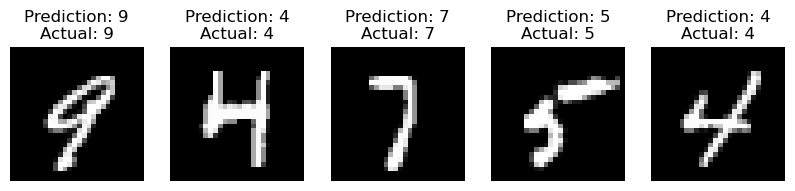

In [53]:
predictions = []
count = 5
x = []
y = []
for i in range(count):
    i_x = np.random.randint(0, x_test.shape[0])
    x.append(x_test[i_x])
    y.append(y_test[i_x])
    predictions.append(model.predict(x_test[i_x]))
visualize(x, predictions, y, count)